# Pre-processing
\
The raw data are point clouds generated by MLS (mobile LiDAR). The very first pre-processing step involves processing by the SLAM algorithm (more specifically, via the application provided by GeoSLAM), and unzip files.

Then, the next part consists in classifying ground points, generating a DTM, and extracting vegetation points in a slice parallel to DTM. This step is carried out using the opensource software Computree, and is detailed in the file computree_steps.xsct2 (it is ready to use, only the input files need to be selected and the output folder specified, parameters can also be viewed and modified).

Note: depending on the device you are using, it may be necessary to tile the point cloud before processing with Computree. In this case, make sure you convert to point format 7 and merge the output tile files before moving on. I recommend using CloudCompare for tiling and for converting .laz to .las.

*Output folder: 'computree_outputs'*

# Clustering
\
A shape (branch, trunk, etc.) is characterised by a high point density. To eliminate noise such as foliage, point clouds are clustered using a DBSCAN (density-based spatial clustering of applications with noise) algorithm. The resulting clusters are then clustered more finely using the HDBSCAN method. Clusters are then filtered in order to eliminate high branches, shapes that are mostly outside the inventory plot (radius 18m), and shapes not long enough.

The clustering results are exported as a point cloud (.las file), and as individual cluster images for classification.

*Input folder: 'computree_outputs'*  
*Output folders: 'clusters_las' (.las files), 'clusters_img' (.png files)*

In [ ]:
# Loading packages and modules
import os
import glob
import laspy
from clustering import ClEngine, Cluster

las_files_path = 'computree_outputs' # location of preprocessed files
clusters_las_path = 'clusters_las' # location of clustered .las files
clusters_img_path = 'clusters_img' # location of cluster images

# Cluster image params
figsize = (4,4)
dpi = 75

# Listing all .las files to cluster
las_files = glob.glob('computree_outputs/*.las')

# Listing already clustered files
clustered = glob.glob(clusters_las_path + '/*.las')
clustered_names = [os.path.splitext(os.path.basename(file))[0] for file in clustered]

In [ ]:
for file in las_files:
    
    # Checking if the file is not already clustered
    if os.path.splitext(os.path.basename(file))[0]+'_cl' not in clustered_names:
        
        cl = ClEngine(file)
        
        # Cluster .las file points with DBSCAN
        cl.DBSCAN_clustering(eps=0.04, min_samples=50)
        cl.save_all_points(folder=clusters_las_path, suffix="dbscan") # backup of DBSCAN clusters
        
        # Cluster points finely using HDBSCAN algorithm
        cl.HDBSCAN_clustering(min_cluster_size=400, max_cluster_size=200000, min_samples=10)
        cl.save_all_points(folder=clusters_las_path, suffix="hdbscan") # backup of HDBSCAN clusters
        
        # Filter clusters given on a minimum number of points, distance from the plot centre, distance from the ground,
        # and minimum length. Set argument to None to ignore filter.
        cl.filtering(delta=0.5, min_dist=0.8)
        
        # Save final clustering results in a new .las file
        cl.save_all_points(folder=clusters_las_path, suffix="cl")
        
        # Save clustering results in .png files
        cl.save_individual_images(folder=clusters_img_path, figsize=figsize, dpi=dpi)

## NNCLR model building
\
The aim is not to spend our time manually classifying images, so we will be using a NNCLR model, adapted to a small labelled training set. The NNCLR model used here is based on the example of https://keras.io/examples/vision/nnclr/ (see link for more details).



*Input/output folder: 'NNCLR_data', containing images for training*

```
NNCLR_data
│
├── labelled
│   ├── deadwood
│   │   ├── image1.png
│   │   ├── image2.png
│   │   ├── ...
│   │
│   └── other
│       ├── image1.png
│       ├── image2.png
│       ├── ...
│
└── unlabelled
    └── unlabelled
        ├── image1.png
        ├── image2.png
        ├── ...
```


In [1]:
import os
import tensorflow as tf
import image_classification as imgclf

model_path = 'NNCLR_data' # path with labelled and unlabelled images for training
save_path = model_path + '/finetuning_model'
device = 'CPU:0'
batch_size = 32
num_epochs = 50 # max number of epochs, the model will stop automatically when val_p_loss has not increased for 5 epochs
image_size = (300, 300) # in pixels

If GPU memory is insufficient, the CPU can be used (calculations will take longer). Use :

```
with tf.device('CPU:0'):
    ...
```

Model hyperparameters, for information:

```
input_shape = (image_size[0], image_size[1], 3)
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 5000   
temperature = 0.1
queue_size = 10000
width = 128
```


Found 418 files belonging to 2 classes.
Using 335 files for training.
Found 418 files belonging to 2 classes.
Using 83 files for validation.
Found 1032 files belonging to 1 classes.
Building NNCLR model.
Epoch 1/50
20/20 [==============================] - 112s 5s/step - c_loss: 2.6087 - c_acc: 1.0000 - r_acc: 0.5118 - p_loss: 2.3996 - p_acc: 0.1122 - val_p_loss: 0.9047 - val_p_acc: 0.6562
Epoch 2/50
20/20 [==============================] - 111s 5s/step - c_loss: 1.1380 - c_acc: 1.0000 - r_acc: 0.5511 - p_loss: 1.9980 - p_acc: 0.6022 - val_p_loss: 1.7021 - val_p_acc: 0.5156
Epoch 3/50
20/20 [==============================] - 113s 6s/step - c_loss: 0.5970 - c_acc: 1.0000 - r_acc: 0.4641 - p_loss: 2.1053 - p_acc: 0.5396 - val_p_loss: 1.9206 - val_p_acc: 0.5938
Epoch 4/50
20/20 [==============================] - 123s 6s/step - c_loss: 0.4097 - c_acc: 1.0000 - r_acc: 0.4557 - p_loss: 2.2349 - p_acc: 0.5127 - val_p_loss: 1.9618 - val_p_acc: 0.5156
Epoch 5/50
20/20 [==========================

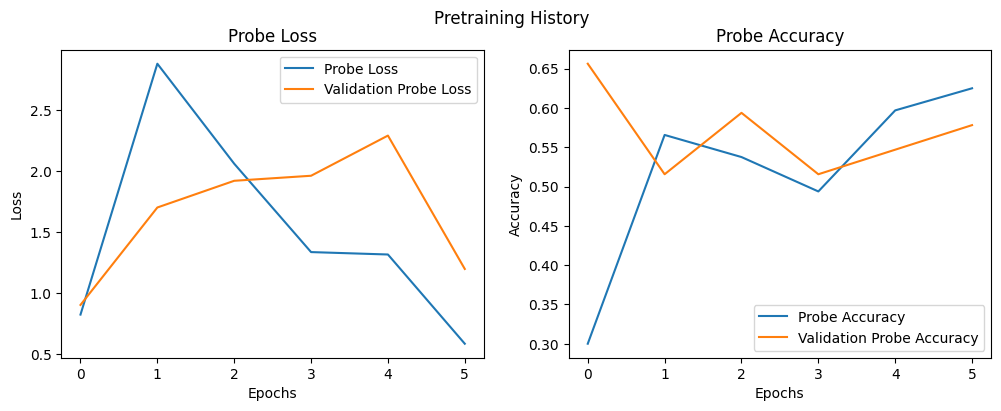

Epoch 1/50
20/20 [==============================] - 45s 2s/step - loss: 6.2819 - acc: 0.6781 - val_loss: 19.5391 - val_acc: 0.0781
Epoch 2/50
20/20 [==============================] - 43s 2s/step - loss: 2.6174 - acc: 0.7844 - val_loss: 8.7259 - val_acc: 0.1875
Epoch 3/50
20/20 [==============================] - 43s 2s/step - loss: 1.5464 - acc: 0.7563 - val_loss: 2.2804 - val_acc: 0.4844
Epoch 4/50
20/20 [==============================] - 44s 2s/step - loss: 1.3477 - acc: 0.7656 - val_loss: 52.8002 - val_acc: 0.0000e+00
Epoch 5/50
20/20 [==============================] - 44s 2s/step - loss: 1.3944 - acc: 0.7844 - val_loss: 19.6403 - val_acc: 0.0000e+00
Epoch 6/50
20/20 [==============================] - 46s 2s/step - loss: 1.0044 - acc: 0.8125 - val_loss: 16.1656 - val_acc: 0.0000e+00
Epoch 7/50
20/20 [==============================] - 47s 2s/step - loss: 0.6871 - acc: 0.8250 - val_loss: 16.1157 - val_acc: 0.3438
Epoch 8/50
20/20 [==============================] - 48s 2s/step - loss: 0

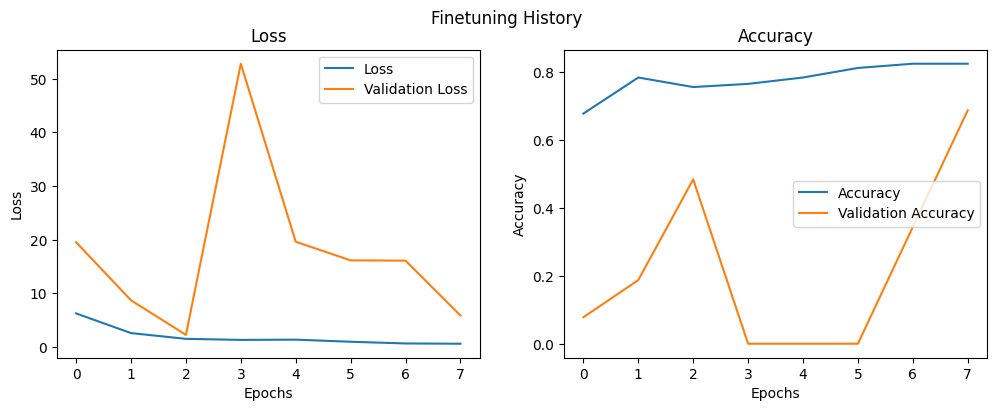

INFO:tensorflow:Assets written to: NNCLR_data/finetuning_model\assets


INFO:tensorflow:Assets written to: NNCLR_data/finetuning_model\assets


In [2]:
with tf.device(device):

    # Initialise the model
    model = imgclf.Model(model_path, image_size, batch_size, num_epochs)

    # Prepare training and validation datasets
    model.prepare_dataset()

    # Pre-train NNCLR
    model.pretraining()

    # Evaluate the model
    model.finetuning(save_path=save_path)

## Image classification
\
*Input folders: 'NNCLR_data', 'clusters_las', 'clusters_img'*  
*Output folder: 'deadwood'*

In [ ]:
import os
import glob
import laspy
import numpy as np
import tensorflow as tf
import image_classification as imgclf
from clustering import ClEngine, Cluster, label_from

# Needed paths
model_path = 'NNCLR_data'
save_path = model_path + '/finetuning_model'
path_las = 'clusters_las'
path_img = 'clusters_img'
path_dw = 'deadwood'

device = 'CPU:0'
batch_size = 32
num_epochs = 50
image_size = (300, 300)

# Get already classified file names
classified_files = glob.glob(path_dw+'/*.las')
classified_names = [os.path.splitext(os.path.basename(file))[0] for file in classified_files]

In [ ]:
with tf.device(device):

    # Re-create model
    model = imgclf.Model(model_path, image_size, batch_size, num_epochs)
    model.load(save_path)

In [ ]:
with tf.device(device):

    # Browse of each study area folder
    for folder in glob.glob(path_img+'/*'):

        folder_name = os.path.splitext(os.path.basename(folder))[0]

        # Check if classification is not already done
        if folder_name + '_deadwood' not in classified_names:

            las_file = path_las + '/' + folder_name + '_clusters.las'

            # Load clusters
            cl = ClEngine(las_file)

            # List of cluster images
            images = glob.glob(folder+'/*.png')

            # Make a prediction with the model: each image classified as deadwood by the model, and
            # classified as "other" but with a score < threshold are kept in the final point cloud
            deadwood_images = model.prediction(images, threshold=0.6)

            # List of clusters (cluster labels) classified as deadwood
            deadwood_labels = [label_from(image) for image in deadwood_images]

            # Keep clusters classified as deadwood
            cl.keep_clusters(cluster_list=deadwood_labels)

            # Save clusters classified as deadwood
            cl.save_all_points(folder=path_dw, suffix='deadwood')
            cl.save_individual_points(folder=path_dw)